In [1]:
%reload_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('../../modules')

import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

from env.gridworld import RandomWalk
from policy import EpsilonGreedyPolicy
from algo.dp import PolicyIteration, PolicyEvaluation
from algo.td import NStepTDPrediction

In [278]:
nrows, ncols = 1, 21
num_states = 21

grid_type_array = pd.read_csv("../grid_type_arrays/corridor_19.csv").fillna(0).to_numpy()[:nrows, 1:ncols+1]
reward_array = pd.read_csv("../grid_type_arrays/corridor_19_rewards.csv").fillna(0).to_numpy()[:nrows, 1:ncols+1]

In [279]:
grid_type_array

array([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 2.]])

In [280]:
reward_array

array([[-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [281]:
np.random.seed(30)

for i in range(10):
    
    rw = RandomWalk(grid_type_array, reward_array)
    rw.reset()

    states = [rw.current_coord[1]]
    while not rw.is_episode_terminated():
        state, reward = rw.step(np.random.randint(2))
        states.append(state[1])
        
    print(states[-1])

20
20
20
20
0
0
20
0
20
0


In [282]:
policy = EpsilonGreedyPolicy(epsilon=1, q=np.zeros(rw.action_space_shape))

In [283]:
pe = PolicyEvaluation(
    env=rw,
    policy=policy,
    discount_factor=1,
    pe_tol=1e-17
)
pe.run()

Running DP policy evaluation ...
Result: Convergence reached.


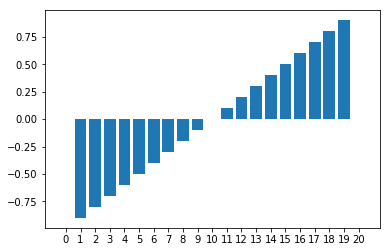

In [13]:
plt.bar(np.arange(ncols), pe.q.mean(axis=-1).flatten())
plt.xticks(np.arange(ncols))
plt.show()

In [86]:
from tqdm.notebook import tqdm

In [598]:
seed=30

for_each_n = []
learned_vs_s = []
for n in tqdm([1, 2, 4, 8, 16, 32, 64]):
    for_each_alpha = []
    learned_vs = []
    for alpha in tqdm(np.arange(0, 1+0.1, 0.1), leave=False):
        for_each_run = []
        for run in tqdm(range(1), leave=False):
            nstep = NStepTDPrediction(rw, policy, alpha=alpha, n=n, gamma=1, true_v=pe.q.mean(axis=-1))
            rms_error = nstep.run(max_iterations=10, which_tqdm=None, seed=seed)
            learned_vs.append(nstep.v)
            for_each_run.append(np.mean(rms_error))
        for_each_alpha.append(np.mean(for_each_run))
    learned_vs_s.append(learned_vs)
    for_each_n.append(for_each_alpha)

In [591]:
# with open('effect_of_n_and_alpha.json', 'w+') as json_f:
#     json.dump(for_each_n, json_f)

In [592]:
# with open('effect_of_n_and_alpha.json', 'r') as json_f:
#     for_each_n = json.load(json_f)

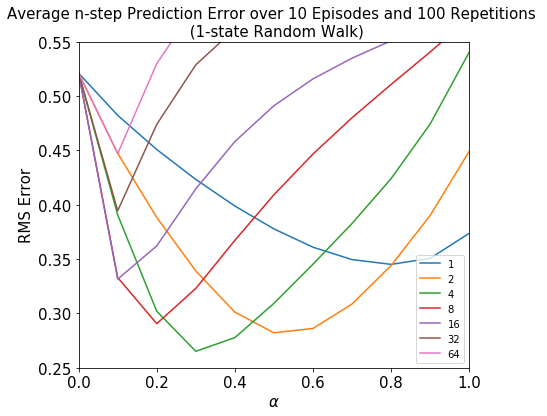

In [599]:
plt.figure(figsize=(7, 6))
for ix, each_n in enumerate(for_each_n):
    
    plt.plot(np.arange(0, 1+0.1, 0.1), each_n, label=[1, 2, 4, 8, 16, 32, 64][ix])
    
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0.25, 0.55)
plt.xlim(0, 1.0)

plt.title(f'Average n-step Prediction Error over 10 Episodes and 100 Repetitions \n ({ncols-2}-state Random Walk)', fontsize=15)
plt.xlabel(r'$\alpha$', fontsize=15)
plt.ylabel('RMS Error', fontsize=15)
plt.legend(loc='lower right')
plt.show()

In [601]:
ns = [1, 2, 4, 8, 16, 32, 64]
alphas = np.arange(0, 1+0.1, 0.1)

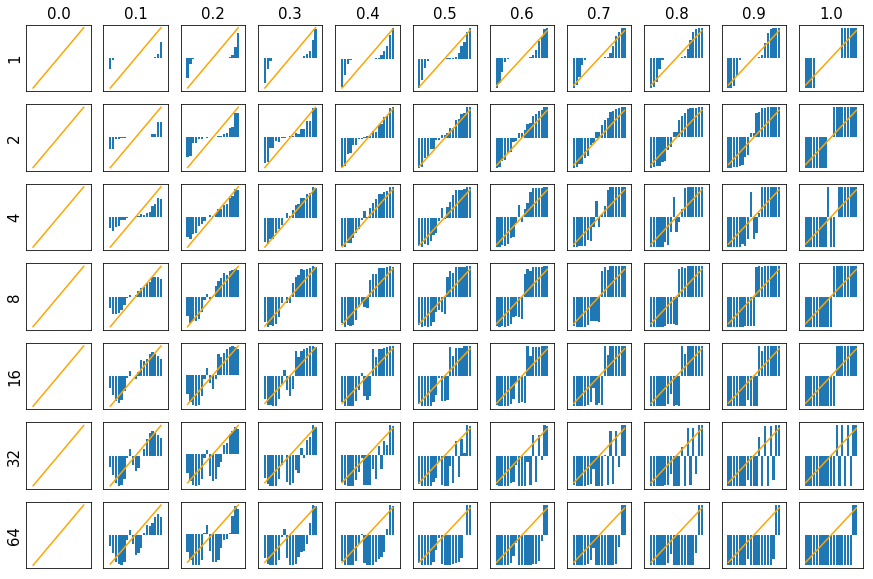

In [606]:
fig, axs = plt.subplots(nrows=len(ns), ncols=len(alphas), figsize=(15, 10))
for i in range(len(ns)):
    for j in range(len(alphas)):
        axs[i, j].plot([1, 19], [-0.9, 0.9], color='orange')
        axs[i, j].bar(np.arange(num_states), learned_vs_s[i][j].flatten())
        axs[i, j].set_xticks([]); axs[i, j].set_yticks([]);
        if i == 0:
            axs[i, j].set_title(round(alphas[j], 1), fontsize=15)
        if j == 0:
            axs[i, j].set_ylabel(int(ns[i]), fontsize=15)
plt.savefig('learned_value_tables_after_10_epsides_19_state_random_walk.png', dpi=500, bbox_inches='tight', pad_inches=0)

In [623]:
alpha = 0.1
n = 64

In [624]:
nstep = NStepTDPrediction(rw, policy, alpha=alpha, n=n, gamma=1, true_v=pe.q.mean(axis=-1))
np.random.seed(30)
vs = []
for i in range(10):
    _ = nstep.run(max_iterations=1, which_tqdm='notebook', seed=None)
    vs.append(nstep.v.copy())

In [625]:
import seaborn as sns

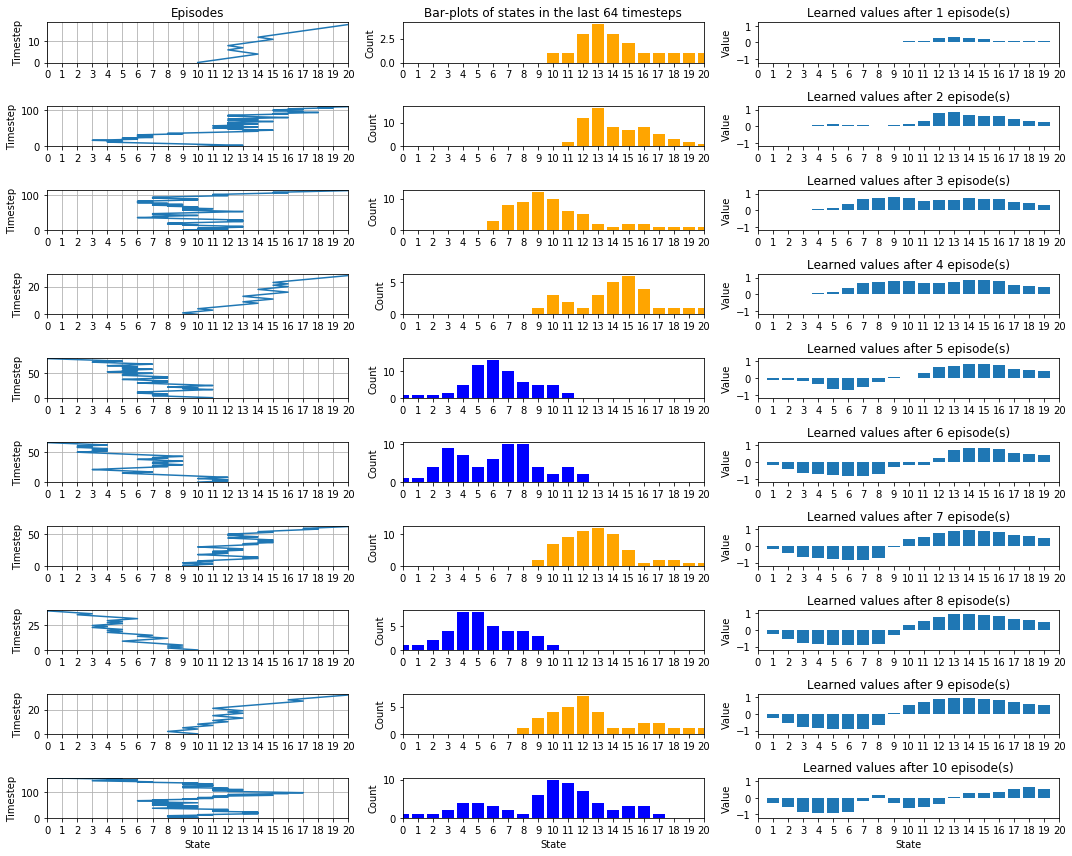

In [626]:
np.random.seed(30)

states_s = []
terminal_states = []

for i in range(10):
    
    rw = RandomWalk(grid_type_array, value_array)
    rw.reset()

    states = [rw.current_coord[1]]
    while not rw.is_episode_terminated():
        state, reward = rw.step(np.random.randint(2))
        states.append(state[1])
        
    states_s.append(states)
    terminal_states.append(states[-1])

nrows, ncols = 10, 3
num_states = 21
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*1.2))
axs = axs.reshape(nrows, ncols)
for i in range(nrows):
    for j in range(ncols):
        ax = axs[i, j]
        
        if j == 0:
            
            ax.plot(states_s[i], np.arange(len(states_s[i])))
            ax.set_xlim(0, 20); ax.set_xticks(np.arange(num_states))
            ax.set_ylim(0, len(states_s[i]))
            ax.grid()
            
            if i == nrows - 1:
                ax.set_xlabel('State')
                
            ax.set_ylabel('Timestep')
            
            if i == 0:
                ax.set_title('Episodes')
            
        elif j == 1:
            
#             updates = np.array(updates_s[i])
            if terminal_states[i] == 20:
                color = 'orange'
            else:
                color = 'blue'
#             updates = updates[mask]
                
#             useful_updates = np.array(useful_updates_s[i])[mask]
#             total_updates_per_state = np.zeros((num_states, ))
#             for state in range(num_states):
#                 total_updates_per_state[state] += 0.2 * np.sum(updates[useful_updates == state])
              
#             ax.bar(np.arange(num_states), total_updates_per_state, color=color)

            states = np.array(states_s[i])[-n:]

            counts = np.zeros((num_states, ))
            for state in range(num_states):
                counts[state] = np.sum(states == state)
    
            ax.bar(np.arange(num_states), counts, color=color)
            ax.set_xticks(np.arange(num_states))

            ax.set_xlim(0, 20)
        
            if i == nrows - 1:
                ax.set_xlabel('State')
                
            ax.set_ylabel('Count')
            
            if i == 0:
                ax.set_title(f'Bar-plots of states in the last {n} timesteps')
        
        elif j == 2:
        
            ax.bar(np.arange(num_states), vs[i].flatten())
            ax.set_xticks(np.arange(num_states))
            ax.set_xlim(0, 20); ax.set_ylim(-1.2, 1.2)
            if i == nrows - 1:
                ax.set_xlabel('State')
            ax.set_ylabel('Value')
            
            ax.set_title(f'Learned values after {i+1} episode(s)')
            
plt.tight_layout()
plt.savefig(f'learning_dynamics_19_state_random_walk_n_{n}_alpha_{alpha}.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [611]:
all_states = []

for i in range(1000):
    
    rw = RandomWalk(grid_type_array, reward_array)
    rw.reset()

    states = [rw.current_coord[1]]
    while not rw.is_episode_terminated():
        state, reward = rw.step(np.random.randint(2))
        states.append(state[1])
        
    all_states.extend(states[-64:])

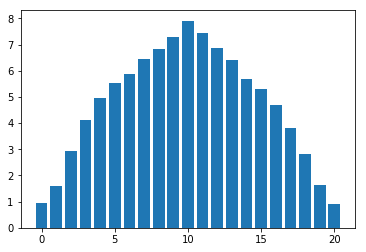

In [612]:
counts = np.zeros((num_states, ))
for state in range(num_states):
    counts[state] = np.sum(np.array(all_states) == state) / len(all_states) * 100
plt.bar(np.arange(num_states), counts)
plt.show()